<a href="https://colab.research.google.com/github/asymptotebag/covid-sentiment-polarity/blob/master/bert_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Token Sentiment Analysis of COVID-19 Topic Tweets


##Preliminary Model/Baseline Results

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
data_root = '/content/drive/MyDrive/6.8610 Final Project/data/'
#data_root = '/Users/ryznerf/Library/Mobile Documents/com~apple~CloudDocs/MIT/nlp_proj/data/'

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install torchmetrics
!pip install nltk

import nltk
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 27.6 MB/s 
     |████████████████████████████████| 182 kB 77.1 MB/s 
     |████████████████████████████████| 7.6 MB 50.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 36.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import torch 
BATCH_SIZE = 32
EPOCH_NUM = 3
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
!nvidia-smi -L

cuda
GPU 0: Tesla T4 (UUID: GPU-5a29cdd4-45ce-b596-023d-8d58e6ba8fe0)


## SEC 0 - SHARED FUNCTIONS

In [ ]:
# TRAIN TEST SPLITTING FUNCTIONS

from sklearn.model_selection import train_test_split

def prepare_data(df_data, random_state = 27, test_perc = 0.2, val_perc = 0.1, sentiment_type = 'binary_sentiment'):
    random_state = 27
    test_perc = 0.2

    X = df_data['text'].to_numpy()
    y = df_data[sentiment_type].to_numpy()

    # train test splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_perc, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= val_perc/(1-test_perc), random_state=random_state)
    
    # test correctness
    assert len(X_train) == len(y_train)
    assert len(X_val) == len(y_val)
    assert len(X_test) == len(y_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# PLOTTING FUNCTIONS

import seaborn as sns

def plot_dataset_dists(df_data, class_type='binary_sentiment'):
    f, axarr = plt.subplots(1, 3, figsize=(20, 5))
    axarr[0].hist(df_data['sentiment'], bins=20, alpha = 0.4, color='blue')
    axarr[0].set_title('Sentiment')

    axarr[1].hist(df_data['norm_sentiment'], bins=20, alpha = 0.4, color='blue')
    axarr[1].set_title('Normalized sentiment')

    sns.countplot(ax = axarr[2],x=df_data[class_type])
    axarr[2].set_title('Binary sentiment balance')
    plt.show()
    
def check_label_set_balance(label_sets):
    train, val, test = label_sets
    
    f, axarr = plt.subplots(1, 3, figsize=(20, 5))
    sns.countplot(ax = axarr[0],x=train)
    axarr[0].set_title('Training binary sentiment balance')
    
    sns.countplot(ax = axarr[1],x=val)
    axarr[1].set_title('Validation binary sentiment balance')
    
    sns.countplot(ax = axarr[2],x=test)
    axarr[2].set_title('Test binary sentiment balance')
    
    plt.show()

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def train_model(model, optimizer, epochs,train_data, val_data):
    print('Training model ...')
    softmax = nn.Softmax(dim=1)
    model.train()
    
    avg_training_loss, avg_train_acc, avg_val_loss, avg_val_acc = [], [], [], []
    
    for epoch in range(epochs):
        total_train_loss = 0
        epoch_correctness = torch.tensor([]).to(device)
        # train for one epoch
        for batch in tqdm(train_data):
            model.zero_grad()
            
            b_tokens = batch[0].to(device)
            b_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            outputs = model(b_tokens, attention_mask=b_mask, labels=b_labels)
            # training accuracy prep
            class_prob = softmax(outputs.logits)
            class_pred = torch.argmax(class_prob, axis=1)
            pred_correctness = (class_pred == b_labels)
            epoch_correctness = torch.cat((epoch_correctness, pred_correctness))

            loss = outputs.loss
            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        
        epoch_avg_train_loss = total_train_loss / len(train_data)
        epoch_avg_train_accuracy = np.sum(epoch_correctness.detach().cpu().numpy()) / (len(train_data)*BATCH_SIZE)
        avg_training_loss.append(epoch_avg_train_loss)
        avg_train_acc.append(epoch_avg_train_accuracy)
        
        # evaluate on validation set after training for one epoch
        epoch_avg_val_accuracy, epoch_avg_val_loss = validation_loop(model, val_data)
        avg_val_loss.append(epoch_avg_val_loss)
        avg_val_acc.append(epoch_avg_val_accuracy)
        
        print('Epoch: {}, Training Loss: {}, Training Acc: {}, Validation Loss: {}, Validation Accuracy: {}'.format(epoch+1, epoch_avg_train_loss, epoch_avg_train_accuracy, epoch_avg_val_loss, epoch_avg_val_accuracy))
        
    return model, {'train_loss': avg_training_loss, 'validation_loss': avg_val_loss, 'train_acc': avg_train_acc, 'validation_acc': avg_val_acc}
        

def validation_loop(model, val_data):
    print("Running Validation...")
    model.eval()
    
    total_eval_accuracy = 0
    total_eval_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_data):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            
            loss = outputs.loss
            logits = outputs.logits
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    avg_val_accuracy = total_eval_accuracy / len(val_data)
    avg_val_loss = total_eval_loss / len(val_data)


    return avg_val_accuracy, avg_val_loss


In [ ]:
import torch
import transformers
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, AdamW
import torch.nn as nn
from tqdm import tqdm

def tokenizer_loop(x_data, y_labels, tokenizer):
    input_ids = []
    attention_masks = []
    for sent in x_data:
        this_encoding = tokenizer.encode_plus(sent, truncation=True, padding='max_length', max_length = 512, return_attention_mask = True, return_tensors = 'pt')
        input_ids.append(this_encoding['input_ids'])
        attention_masks.append( this_encoding['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(y_labels).type(torch.LongTensor)
    tokenized_data = TensorDataset(input_ids, attention_masks, labels)
    
    return tokenized_data

## SEC 1 - Data pre-processing

In [ ]:
import pandas as pd
import numpy as np
import regex as re
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# load prepared dataset
df_tweets = pd.read_csv(os.path.join(data_root, 'preprocessed_tweets.csv'))
df_tweets.head(3)

,Unnamed: 0,id,text,sentiment,tweet,norm_sentiment,binary_sentiment,multiclass_sentiment
0,0,1.342326e+18,we wish a grand success for supreme hero for r...,0.278125,We wish a grand success for Supreme Hero @IamS...,0.639062,1,2
1,1,1.342326e+18,sorry to disappoint but I ve not make a dollar...,-0.750000,"Sorry to disappoint, but I’ve not made a dolla...",0.125000,0,0
2,2,1.342326e+18,this be wild the who change the definition of ...,0.237500,This is wild.\nThe WHO changed the definition ...,0.618750,1,2


In [ ]:
len(df_tweets)

85228

## SEC 2.1: TRAINING Model with Binary limited sentiment

Full dataset


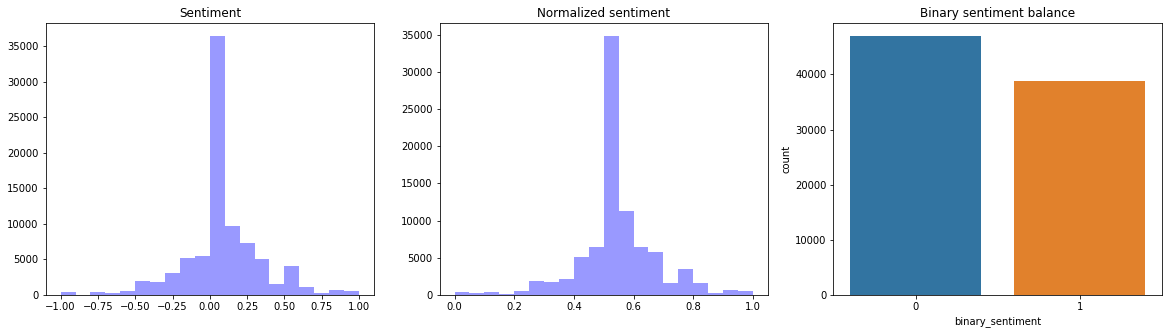

In [ ]:
print('Full dataset')
plot_dataset_dists(df_tweets)

In [ ]:
# LIMIT THE BINARY DATASET TO MORE CONFIDENT REVIEWS
### limit by the normalized sentiment keep values up to 0.3 and from 0.7
UPPER_LOWER_BOUND = 0.65
LOWER_UPPER_BOUND = 0.4
df_tweets_final_binary = df_tweets[(df_tweets['norm_sentiment'] <= LOWER_UPPER_BOUND) | (df_tweets['norm_sentiment'] >= UPPER_LOWER_BOUND)]

print('Limited dataset with {} examples'.format(len(df_tweets_final_binary)))
plot_dataset_dists(df_tweets_final_binary, 'multiclass_sentiment')

In [ ]:
# TRAIN TEST SPLIT
X_train, X_val, X_test, y_train_binary, y_val_binary, y_test_binary = prepare_data(df_tweets_final_binary)

### Torch Dataset pre-paration

In [ ]:
# HYPERPARAMETERS
BATCH_SIZE = 32
EPOCH_NUM = 3
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
!nvidia-smi -L

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# training data
train_dataset = tokenizer_loop(X_train, y_train_binary, tokenizer)
val_dataset = tokenizer_loop(X_val, y_val_binary, tokenizer)
test_dataset = tokenizer_loop(X_test, y_test_binary, tokenizer)

# visualize the set balances
check_label_set_balance([y_train_binary, y_val_binary, y_test_binary])

#Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) #Feel free to experiment with batch sizes
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions = True, output_hidden_states=False, num_labels=2)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-8)

model, res_dict = train_model(model, optimizer, EPOCH_NUM, train_loader, val_loader)

In [ ]:
model.save_pretrained(os.path.join(data_root, 'binary_transformer'))

In [ ]:
## PLOT THE RESULTING TRAIN/VAL PERFORMANCE
train_acc = res_dict['train_acc']
val_acc = res_dict['validation_acc']

plt.plot([i+1 for i in range(len(train_acc))],train_acc, alpha = 0.6, label = 'Training', linestyle='--', marker='o', color = 'blue')
plt.plot([i+1 for i in range(len(train_acc))],val_acc, alpha = 0.6, label = 'Validation', marker='o', color ='red')
plt.xlabel('Epoch')
plt.xticks([i+1 for i in range(len(train_acc))])
plt.ylabel('Accuracy')
plt.title('Accuracy comparison - binary model')
plt.legend()
plt.show()

In [ ]:
## Validate performance on the test set
avg_test_accuracy, avg_test_loss = validation_loop(model, test_loader)

In [ ]:
print('TEST ACCURACY WAS: {}'.format(avg_test_accuracy))

## SEC 2.2: LOADING AND USING PRE-TRAINED BINARY TRANSFORMER

In [ ]:
# HYPERPARAMETERS
BATCH_SIZE = 32
EPOCH_NUM = 5
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
#model_name = 'j-hartmann/sentiment-roberta-large-english-3-classes'
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
!nvidia-smi -L

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
binary_model = AutoModelForSequenceClassification.from_pretrained(os.path.join(data_root, 'binary_transformer')).to(device)

## SEC 3 - TRAINING Model with Neutral Sentiment

In [ ]:
df_tweets = df_tweets.dropna(subset=['text'])

Full dataset


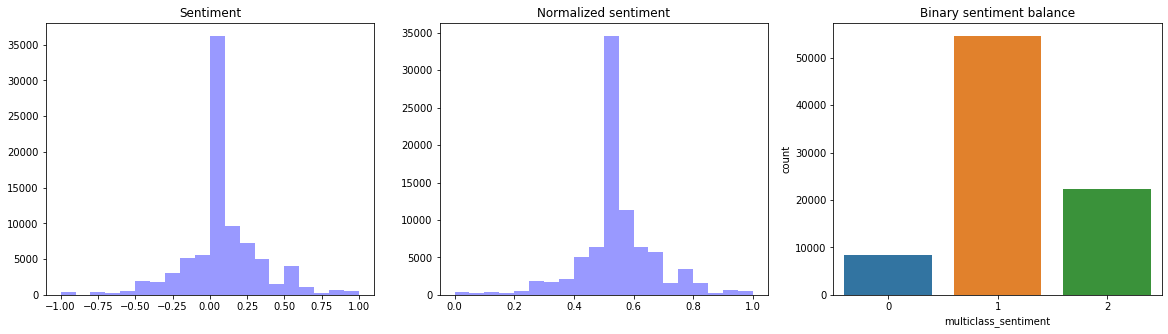

In [ ]:
# super imbalanced .....
print('Full dataset')
plot_dataset_dists(df_tweets, 'multiclass_sentiment')

Lengths are neg: 8364 neutral: 10000 pos: 10000


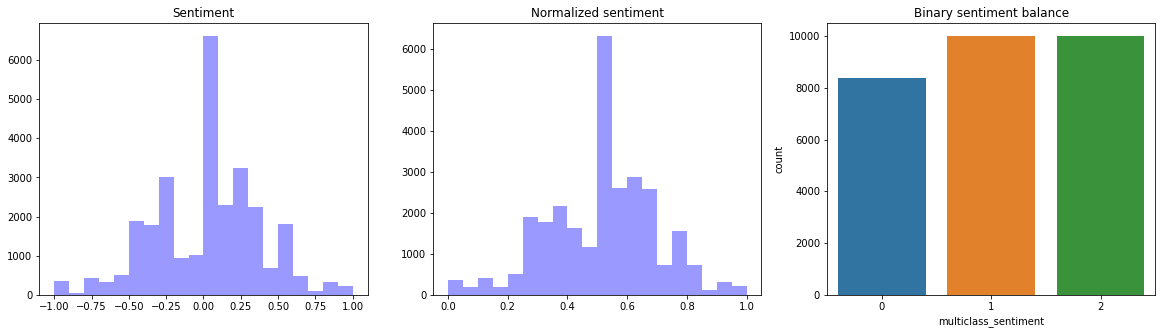

In [ ]:
# DOWNSAMPLE THE TWEETS to have balanced dataset

def sample_tweets(sample_size, df):
    sample_size = min(sample_size, len(df))
    return df.sample(n=sample_size, replace=False)

# sample size
SAMPLE_SIZE = 10000

negative_tweets = sample_tweets(SAMPLE_SIZE, df_tweets[df_tweets['multiclass_sentiment'] == 0])
neutral_tweets = sample_tweets(SAMPLE_SIZE, df_tweets[df_tweets['multiclass_sentiment'] == 1])
positive_tweets = sample_tweets(SAMPLE_SIZE, df_tweets[df_tweets['multiclass_sentiment'] == 2])

print('Lengths are neg: {} neutral: {} pos: {}'.format(len(negative_tweets), len(neutral_tweets), len(positive_tweets)))

# PUT TOGETHER
df_tweets_final_multiclass = pd.concat([negative_tweets, neutral_tweets, positive_tweets])
plot_dataset_dists(df_tweets_final_multiclass, 'multiclass_sentiment')

In [ ]:
duplicate = df_tweets_final_multiclass[df_tweets_final_multiclass['text'].duplicated()]
print('Duplicates remaining: {}'.format(len(duplicate)))
print('Dataset length: {}'.format(len(df_tweets_final_multiclass)))

Duplicates remaining: 0
Dataset length: 28364


In [ ]:
df_tweets_final_multiclass.to_csv(os.path.join(data_root, 'multiclass_dataset_final.csv'))

In [ ]:
X_train, X_val, X_test, y_train_multiclass, y_val_multiclass, y_test_multiclass = prepare_data(df_tweets_final_multiclass, sentiment_type = 'multiclass_sentiment')

In [ ]:
# HYPERPARAMETERS
BATCH_SIZE = 32
EPOCH_NUM = 3
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
!nvidia-smi -L

tokenizer = AutoTokenizer.from_pretrained(model_name)

cuda
GPU 0: Tesla T4 (UUID: GPU-e2541b5d-b08e-0d2a-6fe0-3bfcc86b49c6)


Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

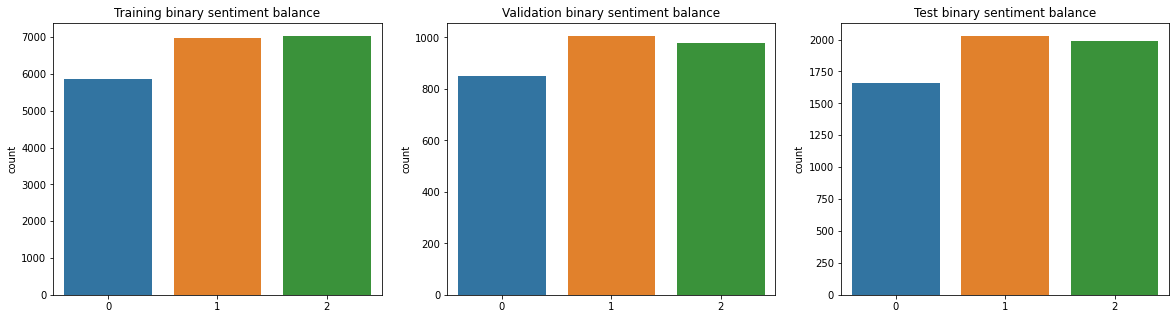

In [ ]:
# training data
train_dataset = tokenizer_loop(X_train, y_train_multiclass, tokenizer)
val_dataset = tokenizer_loop(X_val, y_val_multiclass, tokenizer)
test_dataset = tokenizer_loop(X_test, y_test_multiclass, tokenizer)

# visualize the set balances
check_label_set_balance([y_train_multiclass, y_val_multiclass, y_test_multiclass])

#Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) #Feel free to experiment with batch sizes
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
multiclass_model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions = True, output_hidden_states=False, num_labels=3, ignore_mismatched_sizes=True)
multiclass_model = multiclass_model.to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(multiclass_model.parameters(), lr = 2e-5, eps = 1e-8)
multiclass_model, res_dict = train_model(multiclass_model, optimizer, EPOCH_NUM, train_loader, val_loader)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training model ...


100%|██████████| 621/621 [14:29<00:00,  1.40s/it]


Running Validation...


100%|██████████| 89/89 [00:46<00:00,  1.91it/s]


Epoch: 1, Training Loss: 0.6809284178099194, Training Acc: 0.7036030595813204, Validation Loss: 0.5306229393803672, Validation Accuracy: 0.7864834135901552


100%|██████████| 621/621 [14:01<00:00,  1.35s/it]


Running Validation...


100%|██████████| 89/89 [00:46<00:00,  1.91it/s]


Epoch: 2, Training Loss: 0.4137221391698205, Training Acc: 0.8398752012882448, Validation Loss: 0.45220290224873616, Validation Accuracy: 0.8277487961476726


100%|██████████| 621/621 [14:00<00:00,  1.35s/it]


Running Validation...


100%|██████████| 89/89 [00:46<00:00,  1.91it/s]

Epoch: 3, Training Loss: 0.24648792568696198, Training Acc: 0.9127918679549114, Validation Loss: 0.471962904076228, Validation Accuracy: 0.8323134028892456


In [ ]:
multiclass_model.save_pretrained(os.path.join(data_root, 'multiclass_transformer'))

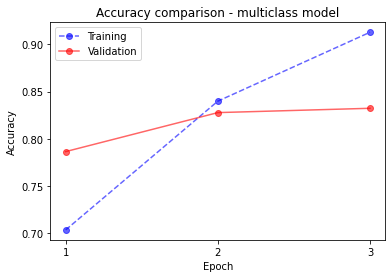

In [ ]:
## PLOT THE RESULTING TRAIN/VAL PERFORMANCE
train_acc = res_dict['train_acc']
val_acc = res_dict['validation_acc']

plt.plot([i+1 for i in range(len(train_acc))],train_acc, alpha = 0.6, label = 'Training', linestyle='--', marker='o', color = 'blue')
plt.plot([i+1 for i in range(len(train_acc))],val_acc, alpha = 0.6, label = 'Validation', marker='o', color ='red')
plt.xlabel('Epoch')
plt.xticks([i+1 for i in range(len(train_acc))])
plt.ylabel('Accuracy')
plt.title('Accuracy comparison - multiclass model')
plt.legend()
plt.show()

In [ ]:
avg_test_accuracy, avg_test_loss = validation_loop(multiclass_model, test_loader)
print('\n TEST ACCURACY WAS: {}'.format(avg_test_accuracy))

Running Validation...


100%|██████████| 178/178 [01:33<00:00,  1.90it/s]


 TEST ACCURACY WAS: 0.8237164481897628


## SEC 3.1 - Loading pretrained multiclass model

In [ ]:
# HYPERPARAMETERS
BATCH_SIZE = 32
EPOCH_NUM = 3
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
!nvidia-smi -L

tokenizer = AutoTokenizer.from_pretrained(model_name)

cuda
GPU 0: Tesla T4 (UUID: GPU-5a29cdd4-45ce-b596-023d-8d58e6ba8fe0)


Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
multiclass_model = AutoModelForSequenceClassification.from_pretrained(os.path.join(data_root, 'multiclass_transformer')).to(device)

In [ ]:
!pip install bertviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 157 kB 17.8 MB/s 
     |████████████████████████████████| 1.3 MB 40.4 MB/s 
     |████████████████████████████████| 132 kB 57.0 MB/s 
     |████████████████████████████████| 79 kB 5.0 MB/s 
     |████████████████████████████████| 10.2 MB 65.7 MB/s 
     |████████████████████████████████| 140 kB 66.8 MB/s 
     |████████████████████████████████| 127 kB 65.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
# Load model and retrieve attention weights

from bertviz import head_view, model_view

model = multiclass_model
# sentence_a = "I hate the quarantine and I am depressed"
sentence_a = "I have the freshman plague" 
# sentence_a = "I think covid is great for the society."
# sentence_a = "we wish a grand success for supreme hero for solobrathukesobetter release first major theatrical release post lockdown watch the movie only in theatre celebratecinema"

inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt')

input_ids = inputs['input_ids'].to(device)
att_mask = inputs['attention_mask'].to(device)

out = model(input_ids, attention_mask=att_mask)
attention = out['attentions']
tokens = tokenizer.convert_ids_to_tokens(input_ids[0]) 

m = nn.Softmax(dim=1)
torch.round(m(out['logits']), decimals=3)

tensor([[0.0540, 0.9140, 0.0330]], device='cuda:0', grad_fn=<RoundBackward1>)

In [ ]:
np.arange(3)

array([0, 1, 2])

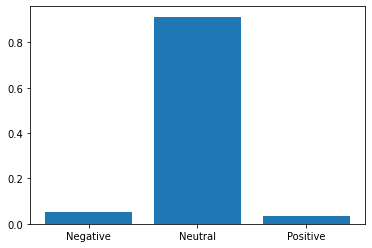

In [ ]:
prediction = m(out['logits']).detach().cpu() 
prediction = prediction.squeeze().numpy() 
bar = plt.bar(["Negative", "Neutral", "Positive"] , prediction)


In [ ]:
head_view(attention,tokens)

<IPython.core.display.Javascript object>

In [ ]:
model_view(attention, tokens)

<IPython.core.display.Javascript object>

## SEC 4 - Attention processing

In [ ]:
def average_across_all(attention, token_index = 0): 
    """
    returns a vector of averaged attention weights across each (12 heads x 6 layers)  
    """
    attn_heads = torch.cat(attention,dim=1).squeeze()
    token_attn_weights = attn_heads[:,token_index,:]
    return torch.mean(token_attn_weights,dim=0)

def cls_average_across_all(attention): 
    """
    returns a vector of averaged attention weights across each (12 heads x 6 layers)  
    """
    attn_heads = torch.cat(attention,dim=1).squeeze()
    token_attn_weights = attn_heads[:, :]
    return torch.mean(token_attn_weights,dim=0)

In [ ]:
def average_across_heads(attention, token_index = 0): 
    """
    returns a (num_layers x num_tokens) tensor of attention weights, averaged across all heads per layer  
    """
    attn_heads = torch.cat(attention,dim=0).squeeze()
    attn_heads = torch.mean(attn_heads, dim = 1)
    return attn_heads[:,token_index,:]

def cls_average_across_heads(attention): 
    """
    returns a (num_layers x num_tokens) tensor of attention weights, averaged across all heads per layer  
    """
    attn_heads = torch.cat(attention,dim=0).squeeze()
    attn_heads = torch.mean(attn_heads, dim = 1)
    return attn_heads[:, :]

In [ ]:
def merge_tokens(attention, tokens):
    """
    attention is a (n-layers = 6)-tuple, where each element of the tuple
    is a [1 x 12 x n_tokens x n_tokens]
  
    returns the merged attentions: (n-layers=6)-tuple, where each element of the
    tuple is a [1 x 12 x n_merged_tokens x n_merged_tokens]
    """
    nlayers = len(attention)
    batch_size, head_size, n_tokens, n_tokens = attention[0].shape

    merged_tokens = []
    # attentions only for [cls]
    merged_attentions = [torch.permute(torch.zeros((batch_size, head_size, 1, n_tokens)), (2, 3, 0, 1)).to(device) for i
                         in range(nlayers)]

    wordi = -1
    for i in range(len(tokens)):
        if (tokens[i].startswith("##")):
            merged_tokens[wordi] += tokens[i][2:]
        else:
            wordi += 1
            merged_tokens.append(tokens[i])

        for li in range(nlayers):
            attention_layer = attention[li]
            if (tokens[i].startswith("##")):
                merged_attentions[li][0:1, wordi:wordi+1, :, :] += torch.permute(attention_layer[:, :, 0:1, i:i + 1], (2, 3, 0, 1))
            else:
                merged_attentions[li][0:1, wordi:wordi+1, :, :] = torch.permute(attention_layer[:, :, 0:1, i:i + 1], (2, 3, 0, 1))

    merged_attentions = [torch.permute(merged_attentions[i], (2, 3, 0, 1))[:, :, :, :wordi + 1] for i in range(nlayers)]
    return merged_attentions, merged_tokens

In [ ]:
from torchmetrics.functional import kl_divergence

def get_highest_kl_layer(layer_average, layer_attentions):
    max_val = -np.inf
    max_pos = None
    for i in range(len(layer_attentions[0])):
        p = layer_average.unsqueeze(0)
        q = layer_attentions[0][i]
        kl = kl_divergence(p, q).detach().cpu().numpy()
        if kl > max_val:
            max_val = kl
            max_pos = i
    return layer_attentions[0][max_pos]

softmax = nn.Softmax(dim=1)

In [ ]:
# HYPERPARAMETERS
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
tokenizer = AutoTokenizer.from_pretrained(model_name)

# prepare data loader across the full data
X = df_tweets_final_multiclass['text'].to_numpy()
y = df_tweets_final_multiclass['multiclass_sentiment'].to_numpy()

analysis_dataset = tokenizer_loop(X, y, tokenizer)

#Data Loaders
analysis_loader = DataLoader(analysis_dataset, batch_size=1, shuffle=False) #Feel free to experiment with batch sizes


In [ ]:
##### EXTRACT ATTENTION HEAD FROM EACH LAYER - THEN AVERAGE - THEN NOTE

from collections import defaultdict
from nltk.corpus import stopwords
from tqdm import tqdm

stop_words = stopwords.words("english")
res_dict = defaultdict(list)
stop_words = set(stop_words)
stop_words.add('[CLS]')
stop_words.add('[SEP]')


for inputs, masking, labels in tqdm(analysis_loader):
    inputs = inputs.to(device)
    masking = masking.to(device)

    inputs = inputs[0][:torch.sum(masking[0])].unsqueeze(0)
    masking = masking[0][:torch.sum(masking[0])].unsqueeze(0)

    model_preds = multiclass_model(inputs, attention_mask=masking)
    attention_scores = model_preds['attentions']
    tokens = tokenizer.convert_ids_to_tokens(inputs[0])
    classification = torch.argmax(torch.round(softmax(model_preds['logits']).detach().cpu(), decimals=3)).cpu().numpy()
    if classification == 1:
        continue
    
    if classification == 0:
        modifier = -1
    else:
        modifier = 1
    
    merged_attentions, merged_tokens = merge_tokens(attention_scores, tokens)
    layer_averages = cls_average_across_heads(merged_attentions)
    
    # append the attention scores average
    attentions = []
    for i in range(len(layer_averages)):
        layer_attention = get_highest_kl_layer(layer_averages[i], merged_attentions[i]).detach().cpu().numpy()[0]
        attentions.append(layer_attention)

    avg_attentions = np.mean(attentions, axis = 0)
    for score, word in zip(avg_attentions, merged_tokens):
        if word in stop_words:
            continue
        res_dict[word].append(score*modifier)

100%|██████████| 28364/28364 [13:27<00:00, 35.13it/s]


In [ ]:
np.mean(res_dict['trump'])

-0.002060012849588641

In [ ]:
import pickle
with open(os.path.join(data_root, 'results_dictionary_averaged_layers.pickle'), 'wb') as handle:
    pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
##### EXTRACT ATTENTION HEAD FROM EACH LAYER - DUMP ALL SCORES SEPARATELY

from collections import defaultdict
from nltk.corpus import stopwords
from tqdm import tqdm

stop_words = stopwords.words("english")
res_dict = defaultdict(list)
stop_words = set(stop_words)
stop_words.add('[CLS]')
stop_words.add('[SEP]')


for inputs, masking, labels in tqdm(analysis_loader):
    inputs = inputs.to(device)
    masking = masking.to(device)

    inputs = inputs[0][:torch.sum(masking[0])].unsqueeze(0)
    masking = masking[0][:torch.sum(masking[0])].unsqueeze(0)

    model_preds = multiclass_model(inputs, attention_mask=masking)
    attention_scores = model_preds['attentions']
    tokens = tokenizer.convert_ids_to_tokens(inputs[0])
    classification = torch.argmax(torch.round(softmax(model_preds['logits']).detach().cpu(), decimals=3)).cpu().numpy()
    if classification == 1:
        continue
    
    if classification == 0:
        modifier = -1
    else:
        modifier = 1
    
    merged_attentions, merged_tokens = merge_tokens(attention_scores, tokens)
    layer_averages = cls_average_across_heads(merged_attentions)
    
    # append the attention scores average
    for i in range(len(layer_averages)):
        layer_attention = get_highest_kl_layer(layer_averages[i], merged_attentions[i]).detach().cpu().numpy()[0]

        for score, word in zip(layer_attention, merged_tokens):
            if word in stop_words:
                continue
            res_dict[word].append(score*modifier)

100%|██████████| 28364/28364 [13:04<00:00, 36.18it/s]


In [ ]:
import pickle
with open(os.path.join(data_root, 'results_dictionary_dump_all_layers_individually.pickle'), 'wb') as handle:
    pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
##### EXTRACT ATTENTION HEAD FROM EACH LAYER - DUMP ALL SCORES SEPARATELY

from collections import defaultdict
from nltk.corpus import stopwords
from tqdm import tqdm

stop_words = stopwords.words("english")
res_dict = defaultdict(list)
stop_words = set(stop_words)
stop_words.add('[CLS]')
stop_words.add('[SEP]')


for inputs, masking, labels in tqdm(analysis_loader):
    inputs = inputs.to(device)
    masking = masking.to(device)

    inputs = inputs[0][:torch.sum(masking[0])].unsqueeze(0)
    masking = masking[0][:torch.sum(masking[0])].unsqueeze(0)

    model_preds = multiclass_model(inputs, attention_mask=masking)
    attention_scores = model_preds['attentions']
    tokens = tokenizer.convert_ids_to_tokens(inputs[0])
    classification = torch.argmax(torch.round(softmax(model_preds['logits']).detach().cpu(), decimals=3)).cpu().numpy()
    if classification == 1:
        continue
    
    if classification == 0:
        modifier = -1
    else:
        modifier = 1
    
    merged_attentions, merged_tokens = merge_tokens(attention_scores, tokens)
    layer_averages = cls_average_across_heads(merged_attentions)
    
    # append the attention scores average - look only at the two last layers
    for i in range(4, len(layer_averages)):
        layer_attention = get_highest_kl_layer(layer_averages[i], merged_attentions[i]).detach().cpu().numpy()[0]

        for score, word in zip(layer_attention, merged_tokens):
            if word in stop_words:
                continue
            res_dict[word].append(score*modifier)

100%|██████████| 28364/28364 [08:31<00:00, 55.44it/s]


In [ ]:
import pickle
with open(os.path.join(data_root, 'results_dictionary_last_two_layers_separate_coefficients.pickle'), 'wb') as handle:
    pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
data_root = '/content/drive/MyDrive/College/2022-23 Fall/6.864/6.8610 Final Project/data'  # (for emily)

In [4]:
from statistics import variance

ATTN_THRESHOLD = 0.1  # min(abs(min(attns)), abs(max(attns))) > threshold to be included
NUM_CONTROVERSIAL = 50  # how many of our top variance words to consider "controversial"

# corpus_attns = {  # is this the format?
#     'apple' : [0.15,0.21,-0.04,0.1],
#     'bear' : [-0.2,-0.8,0.2],
#     'crayon' : [0.002,0.03,-0.07],
# }

# things to try: maybe looking for nouns specifically, or feeding in covid related words
# our preliminary results are clearly dominated by generic sentiment words (e.g. mostly adjectives)
# POS tagging? tagged = nltk.pos_tag(wordsList)

def find_polarizing(corpus_attns):
  corpus_variances = []  # store (word, var) tuples
  print(f"corpus size: {len(corpus_attns)}")
  for word, attns in corpus_attns.items():
      mina, maxa = min(attns), max(attns)
      # attns have to both straddle 0 AND have sufficient room around 0
      if (mina < 0 and maxa > 0) and min(abs(mina), maxa) > ATTN_THRESHOLD:
          corpus_variances.append((word, variance(attns)))
  print(f"eligible size: {len(corpus_variances)}")  # how many did we get rid of?
  corpus_variances.sort(key=lambda x:x[1], reverse=True)  # sort by decreasing variance
  # print(corpus_variances[:NUM_CONTROVERSIAL])
  return corpus_variances[:NUM_CONTROVERSIAL]

In [5]:
import pickle
with open(os.path.join(data_root, 'results_dictionary_averaged_layers.pickle'), 'rb') as jar:
    averaged_layers_dicts = pickle.load(jar)

polarized_averaged_layers = find_polarizing(averaged_layers_dicts)
print(polarized_averaged_layers)

corpus size: 23156
eligible size: 449
[('terrific', 0.12108985811879514), ('clever', 0.06612875682139849), ('hysterically', 0.05694982794228709), ('elementary', 0.04852517836586081), ('rudely', 0.04529963056319603), ('credible', 0.04420920931644744), ('quietly', 0.043912176360801615), ('fur', 0.03620334545336172), ('casual', 0.03540897451499194), ('fascinating', 0.035338084151844286), ('unsure', 0.035159018701439115), ('wicked', 0.03461076802008126), ('logical', 0.03392264207507112), ('unbelievable', 0.03392112439994984), ('lightly', 0.033860015345427055), ('amazed', 0.03383975461411104), ('mindless', 0.03261739085260703), ('evident', 0.030030637373530268), ('wee', 0.029931474178594188), ('jerk', 0.029560633400791916), ('lol', 0.02903889897295814), ('surprising', 0.02876463351517765), ('qualified', 0.027995922946407736), ('solid', 0.027616193281129554), ('lmao', 0.02680825032860574), ('smart', 0.0266482162993448), ('late', 0.026588324727425852), ('decent', 0.025847866060399793), ('abse

In [6]:
with open(os.path.join(data_root, 'results_dictionary_dump_all_layers_individually.pickle'), 'rb') as jar:
    averaged_heads_dicts = pickle.load(jar)

polarized_averaged_heads = find_polarizing(averaged_heads_dicts)
print(polarized_averaged_heads)

corpus size: 23156
eligible size: 3117
[('clever', 0.18367463806442214), ('terrific', 0.1825101366853999), ('lighten', 0.13958121084008673), ('lol', 0.13629871956281722), ('elementary', 0.1361257970590345), ('real', 0.13597851588388038), ('fascinating', 0.13374275027965318), ('unbelievable', 0.13203660946432216), ('bleak', 0.13021598800595352), ('credible', 0.1252028618864433), ('heavy', 0.12291286407157946), ('shocking', 0.12136720094126231), ('awkward', 0.12070229694797888), ('unfair', 0.12061447287400717), ('heavily', 0.12042961155691599), ('rudely', 0.11735124250050523), ('fur', 0.1166935407728924), ('mighty', 0.11657463582208265), ('devastating', 0.11652804692229515), ('fresh', 0.11296589784647315), ('global', 0.11283538064479479), ('honest', 0.11271784728116829), ('scary', 0.11162997751868409), ('genuine', 0.11026641947794374), ('funny', 0.10971984604697067), ('lmao', 0.1086837128647104), ('interesting', 0.1083426379101089), ('drunk', 0.10816683671191106), ('smart', 0.10750640130

In [7]:
with open(os.path.join(data_root, 'results_dictionary_last_two_layers_separate_coefficients.pickle'), 'rb') as jar:
    two_layer_dict = pickle.load(jar)

polarized_two_layer = find_polarizing(two_layer_dict)
print(polarized_two_layer)

corpus size: 23156
eligible size: 1228
[('clever', 0.6182890406037395), ('terrific', 0.5186136371700296), ('fur', 0.38670859993327045), ('elementary', 0.3848819869942206), ('hysterically', 0.370659631638839), ('credible', 0.3673813532862995), ('real', 0.3595906487121678), ('fascinating', 0.35618549555070667), ('amazed', 0.35350777675609385), ('logical', 0.35073740900958056), ('rudely', 0.34225172162010786), ('harmless', 0.33463774245223515), ('unsure', 0.3335700120314214), ('global', 0.32633783012160605), ('developed', 0.3224834211636439), ('smart', 0.31201711123307085), ('quietly', 0.31181208313231956), ('responsive', 0.3076894242729937), ('decent', 0.30694639414311503), ('mighty', 0.29541259826467103), ('bleak', 0.2938135308348035), ('casual', 0.2849523975340187), ('late', 0.2791665258724729), ('nba', 0.27501132664603295), ('solid', 0.2745496709048405), ('responsible', 0.27386942626829147), ('actual', 0.2702283569097447), ('lol', 0.2699314105432259), ('absent', 0.2691304882099162), (